In [6]:
# atom features, bond type, graph connectivity, (x,y,z) coordinates  
#   - when we encode the graph, we're doing it through atom features, bond types, and connectivitity (i.e. which atoms are connected to each other and how?)
#   - the coordinate-based representation is particularly useful 
# rdkit: getreactingbonds() for reaction centre

In [ ]:
# convert MLP to GNN by swapping torch.nn.linear with PyG's GNN operators e.g. GCN layer

In [2]:
import torch
print(torch.__file__)

ModuleNotFoundError: No module named 'torch'

In [1]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

import sys
sys.path.insert(0, "Users/rmhavij/3d-reactions/") # azure again
from ts_vae.data_processors.grambow_processor import ReactionDataset

ModuleNotFoundError: No module named 'torch'

In [59]:
base_path = r'data/'
r_dataset = ReactionDataset(base_path, geo_file = 'train_r') 

data = r_dataset.data
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data = data, val_ratio = 0, test_ratio = 0.7)

In [60]:
class LinearEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinearEncoder, self).__init__()
        # use single GC to get embeddings for nodes here
        self.conv = GCNConv(in_channels, out_channels)
    
    def forward(self, x, edge_index):
        # no relu for linearity
        return self.conv(x, edge_index)
    


In [61]:
num_node_fs = r_dataset.data.num_node_features # = 11
out_channels = 2

# build model and optimiser
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAE(LinearEncoder(num_node_fs, out_channels))
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)


In [62]:
def train():
    model.train()
    opt.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    opt.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [63]:
epochs = 10
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.7680, AP: 0.6264
Epoch: 002, AUC: 0.7680, AP: 0.6265
Epoch: 003, AUC: 0.7679, AP: 0.6264
Epoch: 004, AUC: 0.7664, AP: 0.6250
Epoch: 005, AUC: 0.7664, AP: 0.6250
Epoch: 006, AUC: 0.7629, AP: 0.6231
Epoch: 007, AUC: 0.7559, AP: 0.6192
Epoch: 008, AUC: 0.7312, AP: 0.6054
Epoch: 009, AUC: 0.6988, AP: 0.5866
Epoch: 010, AUC: 0.6637, AP: 0.5645


In [10]:
# look at RM tasks


tensor([6, 6, 6,  ..., 1, 1, 1])

In [ ]:
# lucky's work
# PairFeatures: a manual MP I think. it has to be otherwise what he's doing isn't a GNN at all.

# set edges
#   iterate:
#       compute features (i.e. MP) -> MLP(features) -> update edges
#       compute features (i.e. MP) -> MLP(MLP(edges)) -> update vertices

In [27]:
from sklearn.manifold import TSNE

model.eval()
z = model.encode(x, train_pos_edge_index)
labels = data.z.unique()
#color_list = ["red", "orange", "green", "blue"]
#colors = [color_list[y.item()] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

NameError: name 'plt' is not defined

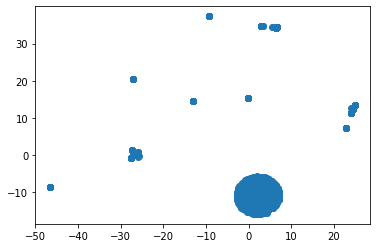

In [28]:
import matplotlib.pyplot as plt

plt.scatter(xs, ys)
plt.show()